# **Sistem Rekomendasi**: Rekomendasi Aplikasi untuk Pengguna di Google Play Store
---
##### Oleh : [Fahmi Jabbar](https://www.dicoding.com/users/fahmijabbar)
##### Proyek Submission 2 - Machine Learning Terapan Dicoding

# **Pendahuluan**

Pada proyek ini akan dibuat sistem rekomendasi aplikasi untuk pengguna di Google Play Store menggunakan *content-based filtering*. Untuk memudahkan navigasi gunakan menu *Table of Contents* di kanan atas Google Colaboratory.

# **1. Mengimpor pustaka/modul python yang dibutuhkan**

In [1]:
# Memasang modul plotly & scikit-learn terbaru
!pip install -U plotly
!pip install -U scikit-learn

     |████████████████████████████████| 23.9 MB 13 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 22.3 MB 65.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# Untuk pengolahan data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Untuk visualisasi data
import plotly.express as px
from plotly.offline import iplot
import missingno as msno

# Untuk pembuatan sistem rekomendasi 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Untuk evaluasi sistem rekomendasi
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# **2. Mempersiapkan Dataset**

## 2.1 Menyiapkan kredensial akun Kaggle

In [3]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

## 2.2 Mengunduh dan Menyiapkan Dataset

![Sampul Dataset](https://user-images.githubusercontent.com/58651943/134548111-e092e12e-7621-4b61-86c5-3bc32bcbbfeb.png)

Informasi Dataset :

Jenis | Keterangan
--- | ---
Sumber | [Kaggle Dataset : Google Play Store Apps](https://www.kaggle.com/adityakadiwal/water-potability)
Lisensi | Creative Commons Attribution 3.0
Kategori | Bisnis, Internet, Sains Komputer 
Rating Penggunaan | 7.1 (Gold)
Jenis dan Ukuran Berkas | zip (9 MB)

In [4]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d lava18/google-play-store-apps

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 65.1MB/s]


In [5]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/google-play-store-apps.zip

Archive:  /content/google-play-store-apps.zip
  inflating: googleplaystore.csv     
  inflating: googleplaystore_user_reviews.csv  
  inflating: license.txt             


# **3. Pemahaman Data** ***(Data Understanding)***

## 3.1 Memuat Data pada sebuah Dataframe menggunakan *pandas*

In [94]:
# Memuat data pada dataframe di variable df dari file googleplaystore.csv
df = pd.read_csv("/content/googleplaystore.csv")

In [95]:
# Pratinjau dataset
df.tail(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device
10840,iHoroscope - 2018 Daily Horoscope & Astrology,LIFESTYLE,4.5,398307,19M,"10,000,000+",Free,0,Everyone,Lifestyle,"July 25, 2018",Varies with device,Varies with device


## 3.2 Uraian variabel pada dataset

In [96]:
# Memuat informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [97]:
# Menghitung jumlah data kosong pada setiap kolom
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

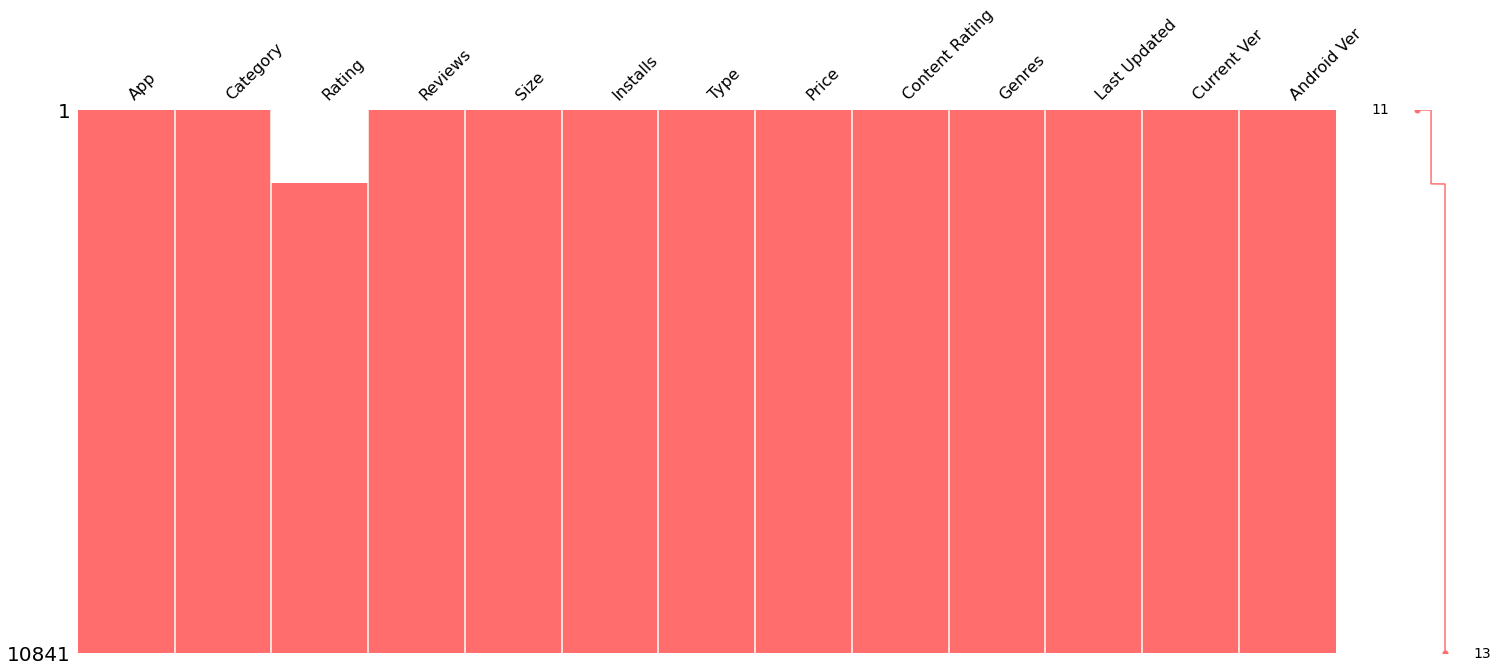

In [98]:
# Memvisualisasikan data kosong pada setiap kolom
sorted_null = msno.nullity_sort(df, sort='ascending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Berkas <code>googleplaystore.csv</code> berisi informasi mengenai detail aplikasi yang ada di Google Play Store. Namun pada datanya masih terdapat banyak sekali nilai kosong seperti pada kolom <code>Rating</code>, <code>Type</code>, <code>Content Rating</code>, <code>Current Ver</code> dan <code>Android Ver</code> 

Kemudian berikut adalah uraian variabel dari setiap kolom pada data : 

1. Kolom <code>App</code> merupakan kolom dengan data nama dari aplikasi.

2. Kolom <code>Category</code> merupakan kolom dengan data jenis kategori dari aplikasi.

3. Kolom <code>Rating</code> merupakan kolom dengan data penilaian pengguna dari aplikasi dalam satuan bintang.

4. Kolom <code>Reviews</code> merupakan kolom dengan data jumlah pengguna yang telah memberi ulasan pada aplikasi

5. Kolom <code>Size</code> merupakan kolom dengan data ukuran dari aplikasi dalam satuan byte.

6. Kolom <code>Installs</code> merupakan kolom dengan data jumlah pengguna yang telah mengunduh dan memasang aplikasi.

7. Kolom <code>Type</code> merupakan kolom dengan data jenis aplikasi yang hanya berisi 2 kategori yakni <i>Paid</i>/berbayar dan <i>Free</i>/gratis.

8. Kolom <code>Price</code> merupakan kolom dengan data harga dari aplikasi dalam satuan dollar.

9. Kolom <code>Content Rating</code> merupakan kolom dengan data kategori usia penggunaan untuk aplikasi, seperti <i>children</i>/<i>adult</i> dsb.

10. Kolom <code>Genres</code> merupakan kolom dengan data kategori dari genre aplikasi. Setiap aplikasi bisa saja memiliki dua genre yang berbeda.

11. Kolom <code>Last Updated</code> merupakan kolom dengan data tanggal terakhir aplikasi di perbaharui oleh pengembang.

12. Kolom <code>Current Ver</code> merupakan kolom dengan data versi terkini aplikasi.

13. Kolom <code>Android Ver</code> merupakan kolom dengan data versi android (minimal) yang dibutuhkan untuk memasang aplikasi.

Selanjutnya, akan dilakukan visualisasi data. Namun, ada beberapa kolom yang perlu diubah tipe datanya seperti kolom <code>Reviews</code>, <code>Install</code>, <code>Price</code>, dan <code>Size</code> pada satuan <i>integer</i>. Lalu kolom <code>Last Updated</code> yang perlu diubah tipe datanya ke <i>datetime</i>. Maka dari itu bagian visualisasi data disatukan dengan bagian persiapan data.
</details>

# **4. Persiapan Data** ***(Data Preparation)*** **dan Visualisasi Data**

## 4.1 Pembersihan data pada setiap kolom

### 4.1.1 Kolom Rating

In [99]:
# Melihat data unik pada kolom rating
df['Rating'].unique()

array([ 4.1,  3.9,  4.7,  4.5,  4.3,  4.4,  3.8,  4.2,  4.6,  3.2,  4. ,
        nan,  4.8,  4.9,  3.6,  3.7,  3.3,  3.4,  3.5,  3.1,  5. ,  2.6,
        3. ,  1.9,  2.5,  2.8,  2.7,  1. ,  2.9,  2.3,  2.2,  1.7,  2. ,
        1.8,  2.4,  1.6,  2.1,  1.4,  1.5,  1.2, 19. ])

In [100]:
# Mencari data rating yang nilainya lebih dari 5
df[df['Rating']>5]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Berdasarkan data unik dari kolom <i>rating</i> terdapat 2 hal yang janggal. Diantanya :

1. Terdapat nilai <i>rating</i> yang lebih dari 5. Maka untuk bagian ini akan dilakukan penghapusan data, karena hanya terdapat 1 data saja yang seperti ini.

2. Terdapat data NaN/kosong pada kolom <i>rating</i>. Untuk bagian ini akan diselesaikan dengan cara melakukan imputasi data dengan KNNImputer. Dengan cara ini, distribusi data rating akan tetap terjaga pada setiap fitur.


</details>

In [101]:
# Melakukan penghapusan baris pada index 10472
df.drop(df.index[10472], axis=0, inplace=True)

In [102]:
# Mencari kembali data rating yang nilainya lebih dari 5
if(len(df[df['Rating']>5]) == 0):
  print("Data rating dengan nilai > 5 sudah dihapus")
else:
  print("Data rating dengan nilai > 5 belum dihapus")

Data rating dengan nilai > 5 sudah dihapus


In [103]:
# Inisiasi objek KNNImputer dengan nilai tentangga = 5 (sesuai setelan awal)
# Dimana 5 merepresentasikan rentang rating
imputer = KNNImputer()

In [104]:
# Melakukan imputasi pada nilai NaN
df['Rating'] = imputer.fit_transform(df[['Rating']]).ravel()
# Membulatkan nilai hasil imputasi dengan 1 koma
df['Rating'] = df['Rating'].round(decimals=1)

In [105]:
# Mencari data rating yang nilainya kosong

if(df['Rating'].isna().sum() == 0):
  print("Data rating dengan nilai NaN sudah diimputasi")
else:
  print("Data rating dengan nilai NaN belum diimputasi")

Data rating dengan nilai NaN sudah diimputasi


### 4.1.2 Kolom Reviews

In [106]:
# Mengubah tipe data kolom reviews menjadi integer
df["Reviews"] = df["Reviews"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  object 
 5   Installs        10840 non-null  object 
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Tipe data kolom Reviews diubah agar sesuai dengan isi dari kolom Reviews, yakni jumlah pengguna yang mengulas aplikasinya.

</details>

### 4.1.3 Kolom Size

In [107]:
# Melihat data unik pada kolom Size
df['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M',
       '31M', '4.2M', '7.0M', '23M', '6.0M', '6.1M', '4.6M', '9.2M',
       '5.2M', '11M', '24M', 'Varies with device', '9.4M', '15M', '10M',
       '1.2M', '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k',
       '3.6M', '5.7M', '8.6M', '2.4M', '27M', '2.5M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '79k', '8.4M', '118k', '44M', '695k', '1.6M',
     

In [108]:
# Mengganti nilai pada kolom size
# Menyesuaikan nilai Megabyte
df['Size']= df['Size'].str.replace('M','000')
# Menyesuaikan nilai Kilobyte
df['Size'] = df['Size'].str.replace('k','')
# Mengganti nilai Varies with device menjadi 0
df['Size'] = df['Size'].replace("Varies with device",'0')
# Mengganti tipe data kolom size
df['Size'] = df['Size'].astype('float')

In [109]:
# Mengkonversi seluruh nilai size pada megabyte
for item in df['Size']:
  # Penyesuaian nilai untuk aplikasi dengan ukuran yang kecil
  if item < 10:
      df['Size'] = df['Size'].replace(item, item*1000)
df['Size'] = df['Size']/1000

In [110]:
# Pratinjau hasil
df['Size'].head(3)

0    19.0
1    14.0
2     8.7
Name: Size, dtype: float64

In [111]:
# Melihat kembali informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  object 
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Agar kolom size dapat dirubah ke tipe data angka, maka perlu dilakukan pemrosesan data. Pertama, setiap akhiran k dan M pada data Size diganti dengan angka, lalu tipe datanya dirubah menjadi <i>float</i>. Setelah itu semua nilai size dikonversi kedalam nilai mega byte.

</details>

### 4.1.4 Kolom Installs

In [112]:
# Melihat data unik pada kolom Installs
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', '0'], dtype=object)

In [113]:
# Menghapus simbol + dan ,
df['Installs'] = df['Installs'].str.replace('+', '')
df['Installs'] = df['Installs'].str.replace(',', '')
# Mengubah tipe data kolom Installs
df['Installs'] = df['Installs'].astype('int')

In [114]:
# Melihat data unik pada kolom Installs
df['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0])

In [115]:
# Mengecek informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          10840 non-null  float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10840 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10840 non-null  object 
 10  Last Updated    10840 non-null  object 
 11  Current Ver     10832 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Agar kolom Installs dapat dirubah ke tipe data angka, maka symbolnya perlu dihilangkan. Setelah itu baru di konversi tipe datanya menjadi integer

</details>

### 4.1.5 Kolom Type

In [116]:
# Melihat jumlah data kosong pada kolom Type
df['Type'].isna().sum()

1

In [117]:
# Mencari data Type = NaN
df[df['Type'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,4.2,0,0.0,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


In [118]:
# Menghapus data NaN
for index in df[df['Type'].isna()].index:
  df.drop(index, axis=0, inplace=True)

In [119]:
# Mencari kembali data rating yang nilainya lebih dari 5
if(df['Type'].isna().sum() == 0):
  print("Data Type dengan nilai NaN sudah dihapus")
else:
  print("Data Type dengan nilai NaN belum dihapus")

Data Type dengan nilai NaN sudah dihapus


In [120]:
# Mengecek informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10839 non-null  object 
 1   Category        10839 non-null  object 
 2   Rating          10839 non-null  float64
 3   Reviews         10839 non-null  int64  
 4   Size            10839 non-null  float64
 5   Installs        10839 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10839 non-null  object 
 8   Content Rating  10839 non-null  object 
 9   Genres          10839 non-null  object 
 10  Last Updated    10839 non-null  object 
 11  Current Ver     10831 non-null  object 
 12  Android Ver     10837 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.2+ MB


### 4.1.6 Kolom Price

In [121]:
# Melihat data unik pada kolom Installs
df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [122]:
# Menghapus simbol $ 
df['Price'] = df['Price'].str.replace('$', '')
# Mengubah tipe data kolom Price
df['Price'] = df['Price'].astype('float')

In [123]:
# Melihat data unik pada kolom Installs
df['Price'].unique()

array([  0.  ,   4.99,   3.99,   6.99,   1.49,   2.99,   7.99,   5.99,
         3.49,   1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,
        24.99,  11.99,  79.99,  16.99,  14.99,   1.  ,  29.99,  12.99,
         2.49,  10.99,   1.5 ,  19.99,  15.99,  33.99,  74.99,  39.99,
         3.95,   4.49,   1.7 ,   8.99,   2.  ,   3.88,  25.99, 399.99,
        17.99, 400.  ,   3.02,   1.76,   4.84,   4.77,   1.61,   2.5 ,
         1.59,   6.49,   1.29,   5.  ,  13.99, 299.99, 379.99,  37.99,
        18.99, 389.99,  19.9 ,   8.49,   1.75,  14.  ,   4.85,  46.99,
       109.99, 154.99,   3.08,   2.59,   4.8 ,   1.96,  19.4 ,   3.9 ,
         4.59,  15.46,   3.04,   4.29,   2.6 ,   3.28,   4.6 ,  28.99,
         2.95,   2.9 ,   1.97, 200.  ,  89.99,   2.56,  30.99,   3.61,
       394.99,   1.26,   1.2 ,   1.04])

In [124]:
# Mengecek informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10839 non-null  object 
 1   Category        10839 non-null  object 
 2   Rating          10839 non-null  float64
 3   Reviews         10839 non-null  int64  
 4   Size            10839 non-null  float64
 5   Installs        10839 non-null  int64  
 6   Type            10839 non-null  object 
 7   Price           10839 non-null  float64
 8   Content Rating  10839 non-null  object 
 9   Genres          10839 non-null  object 
 10  Last Updated    10839 non-null  object 
 11  Current Ver     10831 non-null  object 
 12  Android Ver     10837 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Agar kolom Price dapat dirubah ke tipe data angka, maka symbolnya perlu dihilangkan. Setelah itu baru di konversi tipe datanya menjadi float.

</details>

### 4.1.7 Kolom Last Updated

In [125]:
# Mengubah tipe data kolom last updated
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
# Melihat hasil perubahan tipe data
df.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up


In [126]:
# Mengecek informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10839 non-null  object        
 1   Category        10839 non-null  object        
 2   Rating          10839 non-null  float64       
 3   Reviews         10839 non-null  int64         
 4   Size            10839 non-null  float64       
 5   Installs        10839 non-null  int64         
 6   Type            10839 non-null  object        
 7   Price           10839 non-null  float64       
 8   Content Rating  10839 non-null  object        
 9   Genres          10839 non-null  object        
 10  Last Updated    10839 non-null  datetime64[ns]
 11  Current Ver     10831 non-null  object        
 12  Android Ver     10837 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Agar kolom Last Updated sesuai dengan isinya, maka diperlukan untuk mengubah tipe datanya menjadi <i>datetime</i>

</details>

### 4.1.8 Kolom Current Ver

In [127]:
# Melihat jumlah data kosong pada kolom Current Ver
df['Current Ver'].isna().sum()

8

In [128]:
# Mencari data yang nilai Current Ver = NaN
df[df['Current Ver'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
15,Learn To Draw Kawaii Characters,ART_AND_DESIGN,3.2,55,2.700,5000,Free,0.00,Everyone,Art & Design,2018-06-06,NaN,4.2 and up
1553,Market Update Helper,LIBRARIES_AND_DEMO,4.1,20145,0.011,1000000,Free,0.00,Everyone,Libraries & Demo,2013-02-12,NaN,1.5 and up
6322,Virtual DJ Sound Mixer,TOOLS,4.2,4010,8.700,500000,Free,0.00,Everyone,Tools,2017-05-10,NaN,4.0 and up
6803,BT Master,FAMILY,4.2,0,0.222,100,Free,0.00,Everyone,Education,2016-11-06,NaN,1.6 and up
7333,Dots puzzle,FAMILY,4.0,179,14.000,50000,Paid,0.99,Everyone,Puzzle,2018-04-18,NaN,4.0 and up
7407,Calculate My IQ,FAMILY,4.2,44,7.200,10000,Free,0.00,Everyone,Entertainment,2017-04-03,NaN,2.3 and up
7730,UFO-CQ,TOOLS,4.2,1,0.237,10,Paid,0.99,Everyone,Tools,2016-07-04,NaN,2.0 and up
10342,La Fe de Jesus,BOOKS_AND_REFERENCE,4.2,8,0.658,1000,Free,0.00,Everyone,Books & Reference,2017-01-31,NaN,3.0 and up


In [129]:
# Menghapus data NaN
for index in df[df['Current Ver'].isna()].index:
  df.drop(index, axis=0, inplace=True)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10831 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10831 non-null  object        
 1   Category        10831 non-null  object        
 2   Rating          10831 non-null  float64       
 3   Reviews         10831 non-null  int64         
 4   Size            10831 non-null  float64       
 5   Installs        10831 non-null  int64         
 6   Type            10831 non-null  object        
 7   Price           10831 non-null  float64       
 8   Content Rating  10831 non-null  object        
 9   Genres          10831 non-null  object        
 10  Last Updated    10831 non-null  datetime64[ns]
 11  Current Ver     10831 non-null  object        
 12  Android Ver     10829 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Karena kolom current version merupakan kolom yang esensial bagi informasi aplikasinya, maka apabila dilakukan manipulasi data akan mengakibatkan disinformasi pada pengguna. Selain itu karena datanya sedikit, maka dihapus pun tidak mengapa karena kita tidak akan kehilangan banyak informasi dari data yang ada.

</details>

### 4.1.9 Kolom Android Ver

In [131]:
# Melihat jumlah data kosong pada kolom Android Ver
df['Android Ver'].isna().sum()

2

In [132]:
# Mencari data yang nilai Android Ver = NaN
df[df['Android Ver'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4453,[substratum] Vacuum: P,PERSONALIZATION,4.4,230,11.0,1000,Paid,1.49,Everyone,Personalization,2018-07-20,4.4,NaN
4490,Pi Dark [substratum],PERSONALIZATION,4.5,189,2.1,10000,Free,0.00,Everyone,Personalization,2018-03-27,1.1,NaN


In [133]:
# Menghapus data NaN
for index in df[df['Android Ver'].isna()].index:
  df.drop(index, axis=0, inplace=True)

In [134]:
# Melihat informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10829 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10829 non-null  object        
 1   Category        10829 non-null  object        
 2   Rating          10829 non-null  float64       
 3   Reviews         10829 non-null  int64         
 4   Size            10829 non-null  float64       
 5   Installs        10829 non-null  int64         
 6   Type            10829 non-null  object        
 7   Price           10829 non-null  float64       
 8   Content Rating  10829 non-null  object        
 9   Genres          10829 non-null  object        
 10  Last Updated    10829 non-null  datetime64[ns]
 11  Current Ver     10829 non-null  object        
 12  Android Ver     10829 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1.2+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Karena kolom android version merupakan kolom yang esensial bagi informasi aplikasinya, maka apabila dilakukan manipulasi data akan mengakibatkan disinformasi pada pengguna. Selain itu karena datanya sedikit, maka dihapus pun tidak mengapa karena kita tidak akan kehilangan banyak informasi dari data yang ada.

</details>

## 4.2 Pembersihan data duplikasi

In [135]:
# Melihat jumlah data duplikasi
df.duplicated().sum()

483

In [136]:
# Menghapus data duplikasi
df.drop_duplicates(inplace=True)

In [137]:
# Melihat informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10346 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             10346 non-null  object        
 1   Category        10346 non-null  object        
 2   Rating          10346 non-null  float64       
 3   Reviews         10346 non-null  int64         
 4   Size            10346 non-null  float64       
 5   Installs        10346 non-null  int64         
 6   Type            10346 non-null  object        
 7   Price           10346 non-null  float64       
 8   Content Rating  10346 non-null  object        
 9   Genres          10346 non-null  object        
 10  Last Updated    10346 non-null  datetime64[ns]
 11  Current Ver     10346 non-null  object        
 12  Android Ver     10346 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory usage: 1.1+ MB


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Data duplikasi pada sistem rekomendasi dapat menyebabkan munculnya data yang sama sebanyak 2 kali atau lebih. Dengan demikian agar tidak terjadi hal tersebut, datanya dihapus saja karena sebenarnya data tersebut sudah ada pada dataframe.

</details>

In [138]:
# Hasil data setelah dibersihkan
df.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


## 4.3 Visualisasi Data

In [139]:
# Fungsi untuk plot distribusi data pada suatu kolom numerik
def plot_distribution(column:str, title:str):
  figures = px.histogram(data_frame=df,
                        x=column,
                        color='Type',
                        template='plotly_white',
                        marginal='box',
                        color_discrete_sequence=["#FF7171","#9FD8DF"],
                        barmode='overlay',
                        histfunc='count')

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                  x=0.5,
                                  font=dict(color="#333",size=20)),
                        hoverlabel=dict(bgcolor='white'))

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

# Fungsi untuk plot bar data pada suatu kolom numerik
def plot_bar(column:str, title:str):
  figures = px.bar(data_frame=df,
                  x="Category",
                  y=column, 
                  color="Type", 
                  barmode="group",
                  template='plotly_white',
                  color_discrete_sequence=["#FF7171","#9FD8DF"])

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                  x=0.5,
                                  font=dict(color="#333",size=20)),
                        hoverlabel=dict(bgcolor='white'))

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

# Fungsi untuk plot pie data pada suatu kolom numerik
def plot_category(column:str, title:str):
  figures = px.sunburst(df,
                      path=["Type","Content Rating",column],
                      color="Installs", 
                      color_continuous_scale=["#9FD8DF","#FF7171"])

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                   x=0.5,
                                   font=dict(color="#333",size=20)),
                        title_y=0.96)

  figures.update_traces(hovertemplate="Labels = %{label}<br>Count = %{value}<br>Installed = %{color:.0f} <extra></extra>")

  figures.update_xaxes(
      automargin=True
  )

  iplot(figures)

### 4.3.1 Fitur Numerik

In [140]:
# Menampilkan visualisasi data
for column in ["Rating","Size"]:
    plot_distribution(column=column, title=f"Distribusi fitur numerik pada kolom {column}")

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Berdasarkan hasil visualisasi data diatas :

1. Untuk rating terbanyak dimiliki oleh aplikasi gratis, namun demikian rating tertinggi pada aplikasi gratis dan aplikasi berbayar sama yakni 4.2

2. Untuk size, pada data ini baik pada aplikasi gratis ataupun berbayar banyak yang ukuran aplikasinya < 2 mb

</details>

In [141]:
# Menampilkan visualisasi data
for column in ["Reviews","Price"]:
    plot_bar(column=column, title=f"Distribusi label {column} dengan label kategori<br>Berdasarkan tipe aplikasi")

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Berdasarkan hasil visualisasi data diatas :

1. Untuk review terbanyak dimiliki oleh aplikasi gratis. Pada aplikasi gratis review terbanyak ada pada aplikasi game, sedangkan pada aplikasi berbayar review terbanyak ada pada aplikasi family

2. Untuk price, hanya ada pada kategori aplikasi berbayar dengan jenis aplikasi finance sebagai aplikasi dengan harga yang paling tinggi.

</details>

### 4.3.2 Fitur Kategori

In [142]:
# Menampilkan visualisasi data
for column in ["Category","Genres"]:
    plot_category(column=column, title=f"Distribusi label {column}, Rating Aplikasi dan Tipe Aplikasi<br>Berdasarkan jumlah pengunduh")

# Klik area dalam chart untuk melihat persebaran data yang lebih lengkap

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Berdasarkan hasil visualisasi data diatas :

1. Ada banyak sekali yang informasi yang dapat disimpulkan pada kedua diagram diatas. Misalnya pada label Category, aplikasi yang paling banyak di unduh semua orang adalah aplikasi dengan kategori komunikasi. Begitupun pada label Genre. Untuk melihat informasi lebih detail, silahkan klik area bagian dalam diagram.

2. Label Genre dan Category memiliki data yang kurang lebih sama, perbedaannya label Genre memiliki informasi kategori aplikasi yang lebih detail.

</details>

## 4.4 Restrukturisasi Data

### 4.4.1 Menghapus kolom yang tidak diperlukan

In [144]:
# Menghapus kolom Current Ver
df.drop('Current Ver',inplace=True,axis=1)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,2018-01-07,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,2018-06-08,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,4.4 and up


In [145]:
# Menghapus kolom Last Updated
df.drop('Last Updated',inplace=True,axis=1)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,4.4 and up


In [146]:
# Menyimpan nama-nama aplikasi pada dataframe baru
df_app_name = pd.DataFrame({'App':df['App']})
df_app_name.head()

,App
0,Photo Editor & Candy Camera & Grid & ScrapBook
1,Coloring book moana
2,"U Launcher Lite – FREE Live Cool Themes, Hide ..."
3,Sketch - Draw & Paint
4,Pixel Draw - Number Art Coloring Book


In [147]:
# Menggunakan kolom aplikasi sebagai index
df.set_index('App',inplace=True)
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
App,,,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,4.0.3 and up
Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,4.0.3 and up
Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,4.2 and up
Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,4.4 and up


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Alasan beberapa kolom dihapus diantaranya :

1. Kolom Current Ver, dihapus karena nilainya terlalu variatif dan juga tidak terlalu penting bila dilihat dari sisi pengguna (Dengan asumsi pengguna hanya tertarik pada jenis aplikasi yang serupa saja). Selain itu juga kolom ini tidak merepresentasikan nilai versi aplikasi saat ini.

2. Kolom Last Updated, dihapus karena nilai tanggal disini merupakan tanggal ketika datanya didapatkan (scraping) dan bukan tanggal saat ini.

</details>

### 4.4.2 Konversi label kategori menjadi one-hot encoding

In [148]:
# Memilih semua kolom dengan tipe data object
column_object = df.dtypes[df.dtypes == 'object'].keys()
column_object

Index(['Category', 'Type', 'Content Rating', 'Genres', 'Android Ver'], dtype='object')

In [149]:
# Mengkonversi data kategori ke one-hot encoding
one_hot_label = pd.get_dummies(df[column_object])
one_hot_label.head(3)

,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,...,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word,Android Ver_1.0 and up,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,Android Ver_2.0.1 and up,Android Ver_2.1 and up,Android Ver_2.2 - 7.1.1,Android Ver_2.2 and up,Android Ver_2.3 and up,Android Ver_2.3.3 and up,Android Ver_3.0 and up,Android Ver_3.1 and up,Android Ver_3.2 and up,Android Ver_4.0 and up,Android Ver_4.0.3 - 7.1.1,Android Ver_4.0.3 and up,Android Ver_4.1 - 7.1.1,Android Ver_4.1 and up,Android Ver_4.2 and up,Android Ver_4.3 and up,Android Ver_4.4 and up,Android Ver_4.4W and up,Android Ver_5.0 - 6.0,Android Ver_5.0 - 7.1.1,Android Ver_5.0 - 8.0,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device
App,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Coloring book moana,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
# Menghapus kolom dengan tipe data object
df.drop(column_object,axis=1,inplace=True)
df.head()

,Rating,Reviews,Size,Installs,Price
App,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000,0.0
Coloring book moana,3.9,967,14.0,500000,0.0
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",4.7,87510,8.7,5000000,0.0
Sketch - Draw & Paint,4.5,215644,25.0,50000000,0.0
Pixel Draw - Number Art Coloring Book,4.3,967,2.8,100000,0.0


In [151]:
# Menyatukan one hot encoding dengan seluruh data
df = pd.concat([df,one_hot_label],axis=1)
df.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,...,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word,Android Ver_1.0 and up,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,Android Ver_2.0.1 and up,Android Ver_2.1 and up,Android Ver_2.2 - 7.1.1,Android Ver_2.2 and up,Android Ver_2.3 and up,Android Ver_2.3.3 and up,Android Ver_3.0 and up,Android Ver_3.1 and up,Android Ver_3.2 and up,Android Ver_4.0 and up,Android Ver_4.0.3 - 7.1.1,Android Ver_4.0.3 and up,Android Ver_4.1 - 7.1.1,Android Ver_4.1 and up,Android Ver_4.2 and up,Android Ver_4.3 and up,Android Ver_4.4 and up,Android Ver_4.4W and up,Android Ver_5.0 - 6.0,Android Ver_5.0 - 7.1.1,Android Ver_5.0 - 8.0,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device
App,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Coloring book moana,3.9,967,14.0,500000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",4.7,87510,8.7,5000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sketch - Draw & Paint,4.5,215644,25.0,50000000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pixel Draw - Number Art Coloring Book,4.3,967,2.8,100000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Konversi label kategori menjadi one hot encoding dilakukan untuk memudahkan pencarian nilai terdekat antar sesama aplikasi.

</details>

### 4.4.2 Standarisasi label numerik

In [152]:
# Memilih semua kolom dengan tipe data integer
column_int = df.dtypes[df.dtypes == 'int64'].keys()
column_int

Index(['Reviews', 'Installs'], dtype='object')

In [153]:
# Memilih semua kolom dengan tipe data float
column_float = df.dtypes[df.dtypes == 'float64'].keys()
column_float

Index(['Rating', 'Size', 'Price'], dtype='object')

In [154]:
# Menyatukan semua kolom dengan tipe data numerik
column_numeric = list(column_int) + list(column_float)
column_numeric

['Reviews', 'Installs', 'Rating', 'Size', 'Price']

In [155]:
# Inisiasi minmaxscaler
scaler = MinMaxScaler()

In [156]:
# Melakukan standarisasi data
scaled = scaler.fit_transform(df[column_numeric])

In [157]:
# Mengganti data numerik dengan data yang sudah
# di standarisasi
i=0
for column in column_numeric:
    df[column] = scaled[:,i]
    i += 1

In [158]:
# Melihat hasil standarisasi data
df.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,...,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word,Android Ver_1.0 and up,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,Android Ver_2.0.1 and up,Android Ver_2.1 and up,Android Ver_2.2 - 7.1.1,Android Ver_2.2 and up,Android Ver_2.3 and up,Android Ver_2.3.3 and up,Android Ver_3.0 and up,Android Ver_3.1 and up,Android Ver_3.2 and up,Android Ver_4.0 and up,Android Ver_4.0.3 - 7.1.1,Android Ver_4.0.3 and up,Android Ver_4.1 - 7.1.1,Android Ver_4.1 and up,Android Ver_4.2 and up,Android Ver_4.3 and up,Android Ver_4.4 and up,Android Ver_4.4W and up,Android Ver_5.0 - 6.0,Android Ver_5.0 - 7.1.1,Android Ver_5.0 - 8.0,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device
App,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,0.775,0.000002,0.190,0.00001,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Coloring book moana,0.725,0.000012,0.140,0.00050,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",0.925,0.001120,0.087,0.00500,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sketch - Draw & Paint,0.875,0.002759,0.250,0.05000,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Pixel Draw - Number Art Coloring Book,0.825,0.000012,0.028,0.00010,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [159]:
# Menginspeksi data
df.describe()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,...,Genres_Trivia,Genres_Trivia;Education,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word,Android Ver_1.0 and up,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,Android Ver_2.0.1 and up,Android Ver_2.1 and up,Android Ver_2.2 - 7.1.1,Android Ver_2.2 and up,Android Ver_2.3 and up,Android Ver_2.3.3 and up,Android Ver_3.0 and up,Android Ver_3.1 and up,Android Ver_3.2 and up,Android Ver_4.0 and up,Android Ver_4.0.3 - 7.1.1,Android Ver_4.0.3 and up,Android Ver_4.1 - 7.1.1,Android Ver_4.1 and up,Android Ver_4.2 and up,Android Ver_4.3 and up,Android Ver_4.4 and up,Android Ver_4.4W and up,Android Ver_5.0 - 6.0,Android Ver_5.0 - 7.1.1,Android Ver_5.0 - 8.0,Android Ver_5.0 and up,Android Ver_5.1 and up,Android Ver_6.0 and up,Android Ver_7.0 - 7.1.1,Android Ver_7.0 and up,Android Ver_7.1 and up,Android Ver_8.0 and up,Android Ver_Varies with device
count,10346.000000,1.034600e+04,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,...,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000,10346.000000
mean,0.797414,5.198856e-03,0.181572,0.014173,0.002579,0.006186,0.008216,0.005123,0.022134,0.041272,0.005799,0.035376,0.018945,0.012565,0.010729,0.006186,0.187415,0.034796,0.011985,0.108351,0.029577,0.007732,0.008119,0.036053,0.013242,0.039436,0.025517,0.005799,0.037309,0.031123,0.039339,0.021651,0.027064,0.033926,0.081287,0.022907,0.016915,0.007926,0.926348,0.073652,...,0.003673,0.000097,0.016721,0.000193,0.000290,0.007926,0.002706,0.000193,0.001836,0.011115,0.002996,0.000677,0.012855,0.000097,0.023101,0.062053,0.026967,0.022811,0.000967,0.003480,0.129035,0.000193,0.140247,0.000097,0.229944,0.037309,0.022714,0.086410,0.001063,0.000097,0.000097,0.000193,0.052774,0.002126,0.005606,0.000097,0.004060,0.000290,0.000580,0.117920
std,0.121045,3.452197e-02,0.221508,0.080281,0.040718,0.078411,0.090272,0.071393,0.147127,0.198928,0.075936,0.184737,0.136336,0.111394,0.103028,0.078411,0.390264,0.183272,0.108825,0.310838,0.169424,0.087598,0.089744,0.186430,0.114314,0.194638,0.157697,0.075936,0.189527,0.173659,0.194409,0.145548,0.162277,0.181048,0.273289,0.149616,0.128958,0.088678,0.261216,0.261216,...,0.060496,0.009831,0.128232,0.013903,0.017027,0.088678,0.051955,0.013903,0.042817,0.104847,0.054659,0.026004,0.112655,0.009831,0.150231

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Standarisasi label numerik dilakukan agar rentang nilai pada label numerik hanya antara 0-1 sehingga dapat mempercepat komputasinya

</details>

# **5. Pembuatan Sistem Rekomendasi Content Based Filtering**

## 5.1 Dengan model K-Nearest Neighbor

In [160]:
# Membuat sistem rekomendasi dengan model K-Nearest Neighbor
# Inisiasi model 
model = NearestNeighbors(metric='euclidean')

# Melakukan fitting model terhadap data
model.fit(df)

NearestNeighbors(metric='euclidean')

In [161]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan model KNN
def getRecommendedApps_model(appname:str, recommend_apps:int=5):
  print(f'Apabila pengguna menyukai aplikasi {appname[0]}\n5 aplikasi berikut ini juga mungkin akan disukai :')
  # Mencari aplikasi terdekat dengan aplikasi yang disukai pengguna
  distances, neighbors = model.kneighbors(df.loc[appname],n_neighbors=recommend_apps)
  # Memasukkan aplikasi yang sama pada sebuah list
  similar_app = []
  for appname in df_app_name.loc[neighbors[0][:]].values:
    similar_app.append(appname[0])
  # Memasukan skornya (jarak) pada sebuah list
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  # Mengembalikan sebuah dataframe berupa rekomendasi terhadap aplikasinya
  return pd.DataFrame(data = {"Nama Aplikasi" : similar_app, "Tingkat Kesamaan" : similar_distance})
    

In [162]:
# Memberikan rekomendasi terhadap aplikasi yang
# Serupa dengan Natural recipes for your beauty
getRecommendedApps_model(df_app_name.loc[100])

Apabila pengguna menyukai aplikasi Natural recipes for your beauty
5 aplikasi berikut ini juga mungkin akan disukai :


,Nama Aplikasi,Tingkat Kesamaan
0,"ipsy: Makeup, Beauty, and Tips",100.0%
1,Hush - Beauty for Everyone,99.93%
2,Skin Care and Natural Beauty,99.89%
3,"Sephora: Skin Care, Beauty Makeup & Fragrance ...",99.86%
4,Best Friends Dress Up & Makeup,99.86%


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Dengan model K-Nearest Neighbor, dimana K = 5. Kita dapat melihat hasil rekomendasinya terhadap suatu aplikasi. Bila dilihat secara seksama, hasilnya cukup baik karena relevan dengan aplikasi yang disukai pengguna.

</details>

## 5.2 Dengan Cosine Similarity

In [163]:
# Menghitung cosine similarity dari dataframe
cosine_sim = cosine_similarity(df)

# Menyimpan hasil perhitungan pada dataframe
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_app_name['App'], columns=df_app_name['App'])
cosine_sim_df.head(3)

App,Photo Editor & Candy Camera & Grid & ScrapBook,Coloring book moana,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",Sketch - Draw & Paint,Pixel Draw - Number Art Coloring Book,Paper flowers instructions,Smoke Effect Photo Maker - Smoke Editor,Infinite Painter,Garden Coloring Book,Kids Paint Free - Drawing Fun,Text on Photo - Fonteee,Name Art Photo Editor - Focus n Filters,Tattoo Name On My Photo Editor,Mandala Coloring Book,3D Color Pixel by Number - Sandbox Art Coloring,Photo Designer - Write your name with shapes,350 Diy Room Decor Ideas,FlipaClip - Cartoon animation,ibis Paint X,Logo Maker - Small Business,Boys Photo Editor - Six Pack & Men's Suit,Superheroes Wallpapers | 4K Backgrounds,Mcqueen Coloring pages,HD Mickey Minnie Wallpapers,Harley Quinn wallpapers HD,Colorfit - Drawing & Coloring,Animated Photo Editor,Pencil Sketch Drawing,Easy Realistic Drawing Tutorial,Pink Silver Bow Keyboard Theme,Art Drawing Ideas,Anime Manga Coloring Book,Easy Origami Ideas,I Creative Idea,How to draw Ladybug and Cat Noir,UNICORN - Color By Number & Pixel Art Coloring,Floor Plan Creator,PIP Camera - PIP Collage Maker,How To Color Disney Princess - Coloring Pages,Drawing Clothes Fashion Ideas,...,Fr Ignacio Outreach,FR: My Famous Lover,Fatal Raid - No.1 Mobile FPS,Poker Pro.Fr,Scoreboard FR,SnakeBite911 FR,My FR App,lesparticuliers.fr,Castle Clash: RPG War and Strategy FR,Fr Lupupa Sermons,FR Plus 1.6,Fr Agnel Pune,DICT.fr Mobile,FR: My Secret Pets!,Golden Dictionary (FR-AR),FieldBi FR Offline,HTC Sense Input - FR,Gold Quote - Gold.fr,Fanfic-FR,Fr. Daoud Lamei,Poop FR,PLMGSS FR,List iptv FR,Cardio-FR,Naruto & Boruto FR,Frim: get new friends on local chat rooms,Fr Agnel Ambarnath,Manga-FR - Anime Vostfr,Bulgarian French Dictionary Fr,News Minecraft.fr,payermonstationnement.fr,FR Tides,Chemin (fr),FR Calculator,FR Forms,Sya9a Maroc - FR,Fr. Mike Schmitz Audio Teachings,Parkinson Exercices FR,The SCP Foundation DB fr nn5n,iHoroscope - 2018 Daily Horoscope & Astrology
App,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Photo Editor & Candy Camera & Grid & ScrapBook,1.000000,0.820721,0.997312,0.649872,0.644050,0.821930,0.999545,0.822468,0.823523,0.821979,0.824023,0.823261,0.646476,0.824701,0.822875,0.822628,0.824210,0.996437,0.824348,0.821459,0.999566,0.822286,0.644110,0.824910,0.822839,0.824898,0.998524,0.818818,0.820105,0.999094,0.820374,0.823410,0.822212,0.648252,0.819085,0.651700,0.818812,0.997689,0.820693,0.999806,...,0.480579,0.289857,0.300055,0.292298,0.470539,0.471510,0.466016,0.465007,0.478489,0.479507,0.465925,0.644260,0.465554,0.290413,0.466226,0.466774,0.463428,0.465170,0.264942,0.307837,0.642837,0.465679,0.642960,0.465348,0.289760,0.282391,0.645445,0.452239,0.473602,0.457811,0.467578,0.457245,0.474580,0.461834,0.467527,0.475987,0.478295,0.467501,0.294366,0.474623
Coloring book moana,0.820721,1.000000,0.821256,0.469457,0.641744,0.643173,0.819072,0.641633,0.644059,0.820345,0.644516,0.644129,0.464698,0.646223,0.643501,0.645345,0.645351,0.818109,0.645813,0.640472,0.820549,0.645095,0.641627,0.646895,0.646037,0.821421,0.819848,0.637963,0.640101,0.820654,0.640299,0.644805,0.642218,0.469631,0.637543,0.646883,0.639146,0.821505,0.639932,0.821086,...,0.474418,0.283031,0.288730,0.286050,0.465736,0.464643,0.462319,0.461586,0.472248,0.473347,0.462253,0.641446,0.461985,0.283337,0.462468,0.462852,0.459767,0.461706,0.261500,0.300959,0.640743,0.462076,0.640831,0.455480,0.284304,0.277960,0.642446,0.449270,0.468917,0.455021,0.463398,0.454606,0.470123,0.458643,0.463364,0.467766,0.473246,0.463347,0.289047,0.469136
"U Launcher Lite – FREE Live Cool Themes, Hide Apps",0.997312,0.821256,1.000000,0.655283,0.652430,0.826908,0.995057,0.821389,0.823453,0.829079,0.824869,0.827057,0.651099,0.827966,0.822076,0.829290,0.827647,0.991299,0.825793,0.822581,0.998176,0.829186,0.651151,0.828368,0.829955,0.827992,0.998231,0.821117,0.823637,0.998812,0.823720,0.827953,0.825052,0.658546,0.819932,0.658355,0.823132,0.999953,0.822675,0.

In [164]:
# Membuat fungsi untuk mendapatkan rekomendasi
# Dengan Cosine Similarity
def getRecommendedApps_cosine(appname:str, recommended_apps:int=5):
  print(f'Apabila pengguna menyukai aplikasi {appname[0]}\n5 aplikasi berikut ini juga mungkin akan disukai :')
  # Mencari nilai unik pada aplikasi yang disukai pengguna di baris dataframe cosine sim
  # Nilai unik (arr) dikembalikan dalam bentuk yang berurutan dari kecil ke besar 
  arr, ind = np.unique(cosine_sim_df.loc[appname[0]], return_index=True)
  # Memasukkan nama aplikasi yang serupa dari index kedua terakhir sampai index n terakhir
  similar_app = []
  for index in ind[-(recommended_apps+1):-1]:
    similar_app.append(df_app_name.loc[index][0])
  # Memasukkan skor cosine dari aplikasi yang serupa mulai dari index kedua terakhir sampai index n terakhir
  cosine_score = []
  for score in arr[-(recommended_apps+1):-1]:
    cosine_score.append(score)
  # Mengembalikan sebuah dataframe berupa rekomendasi terhadap aplikasinya
  return pd.DataFrame(data = {"Nama Aplikasi" : similar_app, "Cosine Similarity" : cosine_score}).sort_values(by='Cosine Similarity',ascending=False)

In [177]:
# Memberikan rekomendasi terhadap aplikasi yang
# Serupa dengan Natural recipes for your beauty
getRecommendedApps_cosine(df_app_name.loc[100])

Apabila pengguna menyukai aplikasi Natural recipes for your beauty
5 aplikasi berikut ini juga mungkin akan disukai :


,Nama Aplikasi,Cosine Similarity
4,Hush - Beauty for Everyone,0.999679
3,Skin Care and Natural Beauty,0.998877
2,"Sephora: Skin Care, Beauty Makeup & Fragrance ...",0.998508
1,Best Friends Dress Up & Makeup,0.998508
0,CW Deposit,0.998341


<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Dengan cosine similarity. Kita dapat melakukan hal yang sama yakni membuat sistem rekomendasi terhadap aplikasi yang disukai pengguna. Namun disini dapat kita lihat ada 1 buah aplikasi yang kurang relevan dengan aplikasi yang disukai pengguna yakni CW Deposit (finance).

</details>

# **6. Evaluasi Model K-Nearest Neighbor**

## 6.1 Skor Calinski Harabasz

In [166]:
calinski_harabasz_score(df, df_app_name)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



18.965064890617914

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Skor Calinski Harabasz digunakan untuk menghitung kriteria rasio varian. Metriks ini digunakan pada model clustering seperti yang saat ini sedang digunakan. Skor semakin tinggi ketika cluster padat dan terpisah dengan baik. Pada model ini, nampaknya cluster masih belum padat dan terpisahkan dengan baik.

</details>

## 6.2 Skor Davies Bouldin

In [167]:
davies_bouldin_score(df, df_app_name)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7498301844962899

<details>
  <summary>Buka untuk penjelasan<h4><b>Penjelasan :</b></h4></summary>

Skor Davies Bouldin digunakan untuk menilai separasi tiap cluster dari model. Metriks ini digunakan pada model clustering seperti yang saat ini sedang digunakan. Skor rendah ketika separasi tiap cluster di model terpisahkan dengan baik. Pada model ini skornya cukup kecil sehingga menandakan modelnya sudah memiliki separasi cluster yang baik.

</details>

# Penutupan

Model untuk memberikan rekomendasi aplikasi untuk pengguna di Google Play Store telah selesai dibuat. Setelah diujikan, model ini bekerja cukup baik dalam memberikan 5 rekomendasi teratas terhadap aplikasi yang disukai/diunduh pengguna. Namun demikian, masih ada beberapa kekurangan dari model yang dibuat seperti yang terlihat pada skor Calinski Harabasz dan Davies Bouldin. Untuk memperbaikinya dapat digunakan algoritma untuk membuat model rekomendasi yang lain seperti menggunakan deep learning lalu dibandingkan performanya dengan model KNN saat ini.


### Referensi
- Dokumentasi Scikit-learn : https://scikit-learn.org/stable/modules/classes.html
- Dokumentasi Plotly : https://plotly.com/python/
- Lainnya :
  - https://www.kaggle.com/ahmedmohamedmahrous/google-play-store-eda
  - https://www.kaggle.com/ludovicocuoghi/google-store-deep-eda-rating-prediction-xgboost
  - https://www.kaggle.com/nandalald/android-app-recommendation